# LGBoost Model Preparation

In [57]:
#%pip install lightgbm

In [111]:
spark.stop()

In [106]:
# Setup Environment

import os
import logging
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import set_config
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql
from src.data_preprocessing.data_prep1.sql_queries import sql_queries
import pyspark.sql.functions as F
import xgboost as xgb
from sklearn import set_config
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
import configparser
from pyspark.sql import SparkSession
from src.data_preprocessing.data_prep1.sql_queries import sql_queries
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Window
from src.data_preprocessing.data_prep1.data_utils import (save_parquet, gather_statistics, 
                initialize_environment, load_config, initialize_spark, 
                identify_and_impute_outliers, 
                identify_and_remove_outliers, identify_missing_and_outliers)
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Set global references to None
spark = None
master_results_df = None
race_df = None
df = None

In [107]:

spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()


Spark session created successfully.


In [62]:
race_df = spark.read.parquet(os.path.join(parquet_dir, "race_df_p1.parquet"))

In [63]:
# 11a.) Convert distance from Furlongs (F) to meters if dist_unit is F
    #    1 Furlong ≈ 201.168 meters.
    #    Then change dist_unit to 'm'.

race_df = race_df.withColumn(
    "distance_meters",
    when(upper(trim(col("dist_unit"))) == "F", ((col("distance") / 100)) * lit(201.168))
    .otherwise(lit(None))
)
# Now final_df has "distance_meters" instead of "distance" / "dist_unit"

race_df.select("distance", "dist_unit", "distance_meters").show(10, truncate=False)


+--------+------------------+---------------+
|distance|dist_unit         |distance_meters|
+--------+------------------+---------------+
|850.0   |F                 |1709.928       |
|800.0   |F                 |1609.344       |
|850.0   |F                 |1709.928       |
|800.0   |F                 |1609.344       |
|850.0   |F                 |1709.928       |
|818.0   |F                 |1645.55424     |
|850.0   |F                 |1709.928       |
|600.0   |F                 |1207.008       |
|650.0   |F                 |1307.592       |
|800.0   |F                 |1609.344       |
+--------+------------------+---------------+
only showing top 10 rows



In [64]:
# Step 2: drop the old columns
race_df = race_df.drop("distance", "dist_unit")
race_df = race_df.drop("sa_dist_bk_gate4")


In [65]:
save_parquet(spark, race_df, "race_df_p2", parquet_dir)

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- horse_name: string (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- purse: integer (nullable = true)
 |-- wps_pool: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- equip: string (nullable = true)
 |-- claimprice: double (nullable = true)
 |-- surface: string (nullable = true)
 |-- trk_cond: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- power: double (nullable = true)
 |-- med: string (nullable = true)
 |-- morn_odds: double (nullable = true)
 |-- avgspd: double (nullable = true)
 |-- race_type: string (nullable = true)
 |-- class_rating: integer (nullable = true)
 |-- todays_cls: double (nullable = true)
 |-- net_sentiment: integer (nullable = true)
 |-- stk_clm_md: st

In [66]:
race_df.count()

324041

# Switching to Pandas

In [67]:
# Convert Spark DataFrame -> Pandas DataFrame

race_df = race_df.toPandas()
# Quick info about the DataFrame
#print(df.info())
#print(df.head(5))

In [68]:
#print(race_df.info())
#print(race_df.head(5))

In [69]:
# 4a) Identify columns with high missingness
missing_summary = race_df.isna().sum().sort_values(ascending=False)
print("Missing Value Summary:\n", missing_summary)

Missing Value Summary:
 gps_avg_stride_length    0
jock_win_percent         0
jock_itm_percent         0
trainer_win_percent      0
trainer_itm_percent      0
                        ..
saddle_cloth_number      0
horse_id                 0
horse_name               0
official_fin             0
purse                    0
Length: 80, dtype: int64


In [70]:
race_df["race_id"] = (
    race_df["course_cd"].astype(str) + "_" +
    race_df["race_date"].astype(str) + "_" +
    race_df["race_number"].astype(str)
)

In [71]:
group_array = race_df.groupby("race_id").size().values  # array of group sizes
print(group_array)

[9 8 9 ... 9 9 6]


In [72]:
# If the largest official_fin is 20 (some races can have 20 horses),
# then label = (21 - official_fin).
# So official_fin=1 => label=20, official_fin=2 =>19, etc.
# If your max is 14, you can do (15 - official_fin).  Just ensure "best" horse has largest label.
race_df["rank"] = 21 - race_df["official_fin"]

In [73]:
if "official_fin" in race_df.columns:
    race_df.drop(columns=["official_fin"], inplace=True)

# Check Horser Per Race Distribution

count    41886.000000
mean         7.736260
std          1.956526
min          1.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         20.000000
dtype: float64
1        2
2       24
3      137
4      814
5     3443
6     7834
7     8913
8     7305
9     5206
10    4035
11    2178
12    1879
13      73
14      40
17       1
18       1
20       1
Name: count, dtype: int64


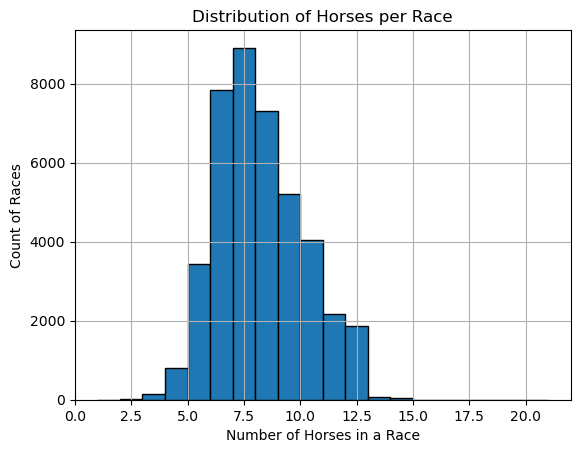

In [74]:
# 1) Count how many horses per race
counts_per_race = race_df.groupby("race_id").size()

# 2) Basic descriptive stats (mean, std, min, max, quartiles)
print(counts_per_race.describe())

# 3) Frequency table of the counts themselves (e.g., how many races had X horses)
print(counts_per_race.value_counts().sort_index())

# 4) Optional: visualize the distribution as a histogram
import matplotlib.pyplot as plt

counts_per_race.hist(bins=range(1, counts_per_race.max() + 2), edgecolor='black')
plt.xlabel("Number of Horses in a Race")
plt.ylabel("Count of Races")
plt.title("Distribution of Horses per Race")
plt.show()

In [75]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["course_cd", "sex", "equip", "surface", "trk_cond", "weather", "med", 
            "race_type", "stk_clm_md", "turf_mud_mark", "layoff_cat"]
for c in cat_cols:
    lbl = LabelEncoder()
    race_df[c] = lbl.fit_transform(race_df[c].astype(str))

In [76]:
race_df = race_df.sort_values("race_id", ascending=True)

In [77]:
features = [
    # Basic numeric columns
    "purse",
    "wps_pool",
    "weight",
    "claimprice",
    "power",
    "morn_odds",
    "distance_meters",
    "avgspd",
    "class_rating",
    "todays_cls",
    "net_sentiment",
    "avg_spd_sd",
    "ave_cl_sd",
    "hi_spd_sd",
    "pstyerl",

    # Cumulative performance stats
    "all_starts",
    "all_win",
    "all_place",
    "all_show",
    "all_fourth",
    "all_earnings",
    "cond_starts",
    "cond_win",
    "cond_place",
    "cond_show",
    "cond_fourth",
    "cond_earnings",

    # Recent form metrics
    "avg_fin_3",
    "avg_beaten_3",
    "avg_speed_3",
    "avg_fin_5",
    "avg_beaten_5",
    "avg_speed_5",
    "speed_improvement",
    "days_off",

    # Sectionals / GPS
    "avgtime_gate1",
    "avgtime_gate2",
    "avgtime_gate3",
    "avgtime_gate4",
    "total_distance_ran",
    "running_time",
    "speed_q1",
    "speed_q2",
    "speed_q3",
    "speed_q4",
    "total_dist_covered",
    "avg_acceleration",
    "net_progress_gain",
    "gps_avg_stride_length",

    # Jockey/Trainer stats
    "jock_win_percent",
    "jock_itm_percent",
    "trainer_win_percent",
    "trainer_itm_percent",
    "jt_win_percent",
    "jt_itm_percent",
    "jock_win_track",
    "jock_itm_track",
    "trainer_win_track",
    "trainer_itm_track",
    "jt_win_track",
    "jt_itm_track",

    # Other
    "age_at_race_day",
    "is_first_race",
]


X_all = race_df[features].values
y_all = race_df['rank'].values
race_ids = race_df['race_id'].values

In [78]:
from sklearn.utils import shuffle

unique_races = race_df['race_id'].unique()
unique_races = shuffle(unique_races, random_state=42)

train_ratio = 0.8
cut = int(len(unique_races) * train_ratio)
train_races = set(unique_races[:cut])
valid_races = set(unique_races[cut:])

# Create a boolean mask
train_mask = race_df['race_id'].isin(train_races)
valid_mask  = race_df['race_id'].isin(valid_races)

# Now slice
X_train = X_all[train_mask]
y_train = y_all[train_mask]
race_id_train = race_ids[train_mask]

X_valid = X_all[valid_mask]
y_valid = y_all[valid_mask]
race_id_valid = race_ids[valid_mask]

In [79]:
import numpy as np

def make_group_array(race_id_array):
    """
    Returns an array of group sizes in the order of race_id_array’s actual row order.
    Expects that race_id_array is sorted or lumps each race contiguously.
    """
    # Approach 1: Rely on the data already being grouped in contiguous rows
    # If your data is not guaranteed to be sorted by race_id, you can sort it first.
    # But let's assume from the train_mask/valid_mask approach that the relative order
    # is consistent. We can just accumulate counts.

    # A simpler approach: group the data by unique race_id in the order they appear
    # and store the size for each chunk.
    # We'll do a loop approach:

    groups = []
    current_race = None
    current_count = 0

    group_sequence = []

    for rid in race_id_array:
        if rid != current_race:
            # if we have an existing group, push it
            if current_race is not None:
                groups.append(current_count)
            current_race = rid
            current_count = 1
        else:
            current_count += 1
    # push the last group
    if current_race is not None and current_count > 0:
        groups.append(current_count)

    return np.array(groups, dtype=np.int32)

group_train = make_group_array(race_id_train)
group_valid  = make_group_array(race_id_valid)

In [80]:
import lightgbm as lgb

train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

valid_dataset = lgb.Dataset(
    X_valid,
    label=y_valid,
    group=group_valid,
    reference=train_dataset
)

In [81]:
# !pip install optuna

In [32]:
import itertools
import lightgbm as lgb

param_grid = {
    "num_leaves": [15, 31, 63],
    "learning_rate": [0.01, 0.05, 0.1],
    "feature_fraction": [0.8, 0.9, 1.0]
}

best_score = float("-inf")
best_params = None

for num_leaves, lr, feat_frac in itertools.product(
    param_grid["num_leaves"],
    param_grid["learning_rate"],
    param_grid["feature_fraction"]
):
    params = {
        "objective": "lambdarank",
        "metric": "ndcg",             # LightGBM may produce ndcg@1, ndcg@2, etc.
        "boosting_type": "gbdt",
        "num_leaves": num_leaves,
        "learning_rate": lr,
        "feature_fraction": feat_frac,
        "verbosity": -1
    }
    
    # Provide names for data sets so best_score keys become ["train", "valid"]
    gbm = lgb.train(
        params,
        train_dataset,
        num_boost_round=500,
        valid_sets=[train_dataset, valid_dataset],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=50)
        ]
    )
    
    # Depending on your metric, LightGBM might store something like "ndcg@1", "ndcg@5", etc.
    # If you only specified "ndcg", typically it logs multiple sub-metrics like ndcg@1..5.
    # You can pick whichever sub-metric you want. For example, "ndcg@5" might be:
    #   gbm.best_score["valid"]["ndcg@5"]
    # If you prefer "ndcg@1", use that key. Below is an example with ndcg@5:
    if "ndcg@5" in gbm.best_score["valid"]:
        score = gbm.best_score["valid"]["ndcg@5"]
    else:
        # fallback: if only "ndcg@1" or plain "ndcg" is stored
        # you can check what's available in gbm.best_score["valid"].keys()
        # For example, if "ndcg" is directly there:
        score = gbm.best_score["valid"].get("ndcg", float("-inf"))

    if score > best_score:
        best_score = score
        best_params = params

print("Best params:", best_params, "Best score:", best_score)

Training until validation scores don't improve for 10 rounds
[50]	train's ndcg@1: 0.696998	train's ndcg@2: 0.750842	train's ndcg@3: 0.795771	train's ndcg@4: 0.82891	train's ndcg@5: 0.851468	valid's ndcg@1: 0.697354	valid's ndcg@2: 0.749028	valid's ndcg@3: 0.796698	valid's ndcg@4: 0.829194	valid's ndcg@5: 0.85084
[100]	train's ndcg@1: 0.711597	train's ndcg@2: 0.765218	train's ndcg@3: 0.80829	train's ndcg@4: 0.839809	train's ndcg@5: 0.860858	valid's ndcg@1: 0.709453	valid's ndcg@2: 0.762388	valid's ndcg@3: 0.807557	valid's ndcg@4: 0.838902	valid's ndcg@5: 0.859324
[150]	train's ndcg@1: 0.731692	train's ndcg@2: 0.782398	train's ndcg@3: 0.82332	train's ndcg@4: 0.852915	train's ndcg@5: 0.872411	valid's ndcg@1: 0.728505	valid's ndcg@2: 0.779201	valid's ndcg@3: 0.82207	valid's ndcg@4: 0.85178	valid's ndcg@5: 0.870245
[200]	train's ndcg@1: 0.748669	train's ndcg@2: 0.796928	train's ndcg@3: 0.836213	train's ndcg@4: 0.863959	train's ndcg@5: 0.88217	valid's ndcg@1: 0.744247	valid's ndcg@2: 0.79295

In [34]:
params = {
    "objective": "lambdarank",
    "metric": "ndcg",          # or "map"
    "boosting_type": "gbdt",
    "num_leaves": 15,
    "learning_rate": 0.1,
    "feature_fraction": 1.0,
    "verbosity": -1
}

In [35]:
# We’ll do early stopping to watch the valid set
gbm = lgb.train(
    params,
    train_dataset,
    num_boost_round=500,
    valid_sets=[train_dataset, valid_dataset],
    valid_names=["train", "valid"],
    # remove early_stopping_rounds=..., 
    # and instead specify callbacks:
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),    # early stopping
        lgb.log_evaluation(period=50)              # optional: log every 50 iters
    ]
)
print("Best iteration:", gbm.best_iteration)

Training until validation scores don't improve for 10 rounds
[50]	train's ndcg@1: 0.801959	train's ndcg@2: 0.84476	train's ndcg@3: 0.876481	train's ndcg@4: 0.898197	train's ndcg@5: 0.911388	valid's ndcg@1: 0.792236	valid's ndcg@2: 0.837077	valid's ndcg@3: 0.871485	valid's ndcg@4: 0.894696	valid's ndcg@5: 0.907307
[100]	train's ndcg@1: 0.843524	train's ndcg@2: 0.879268	train's ndcg@3: 0.905473	train's ndcg@4: 0.922056	train's ndcg@5: 0.932016	valid's ndcg@1: 0.826233	valid's ndcg@2: 0.869467	valid's ndcg@3: 0.898063	valid's ndcg@4: 0.916201	valid's ndcg@5: 0.92632
[150]	train's ndcg@1: 0.866546	train's ndcg@2: 0.89795	train's ndcg@3: 0.920573	train's ndcg@4: 0.934542	train's ndcg@5: 0.94291	valid's ndcg@1: 0.843919	valid's ndcg@2: 0.885634	valid's ndcg@3: 0.910813	valid's ndcg@4: 0.926866	valid's ndcg@5: 0.935598
[200]	train's ndcg@1: 0.883839	train's ndcg@2: 0.911064	train's ndcg@3: 0.931122	train's ndcg@4: 0.943539	train's ndcg@5: 0.950531	valid's ndcg@1: 0.859349	valid's ndcg@2: 0.89

In [36]:
preds = gbm.predict(X_valid)

In [37]:
print(preds)

[ -4.99662379 -12.48886799 -10.62581736 ...  -7.0348425   -7.35584338
  -3.12386357]


# Hyperparameter Tuning with Optuna

In [94]:
import optuna
import lightgbm as lgb

def objective(trial):
    # Hyperparam suggestions
    num_leaves = trial.suggest_int("num_leaves", 16, 32)
    learning_rate = trial.suggest_float("learning_rate", 0.05, 1.0, log=True)
    feature_fraction = trial.suggest_float("feature_fraction", 0.5, 1.0)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 129, 130)
    lambda_l1 = trial.suggest_float("lambda_l1", 0.5, 1.0 )
    lambda_l2 = trial.suggest_float("lambda_l2", 1.0, 1.5)
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.5, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 1, 3)
    num_boost_round = trial.suggest_int("num_boost_round", 1000, 5000)
    
    params = {
        "objective": "lambdarank",
        "metric": "ndcg",           # main metric
        "ndcg_eval_at": [5],        # we want ndcg@5 specifically
        "boosting_type": "gbdt",
        "device_type": "gpu",
        "num_leaves": num_leaves,
        "learning_rate": learning_rate,
        "feature_fraction": feature_fraction,
        "min_data_in_leaf": min_data_in_leaf,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "bagging_fraction": bagging_fraction,
        "bagging_freq": bagging_freq,
        "num_boost_round": num_boost_round,
        "verbosity": -1
    }

    train_dataset = lgb.Dataset(X_train, label=y_train, group=group_train)
    valid_dataset = lgb.Dataset(X_valid, label=y_valid, group=group_valid, reference=train_dataset)

    lgb_model = lgb.train(
        params,
        train_dataset,
        #num_boost_round=5000,
        valid_sets=[train_dataset, valid_dataset],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.log_evaluation(period=100),
            lgb.early_stopping(stopping_rounds=50)
        ]
    )

    # Now you must fetch "ndcg@5"
    best_score_ndcg5 = lgb_model.best_score["valid"]["ndcg@5"]
    return best_score_ndcg5

def run_optuna():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    return study

study = run_optuna()
best_params = study.best_params
best_value = study.best_value   # negative of best ndcg@5
best_ndcg5 = best_value

print("Best params:", best_params)
print("Best ndcg@5:", best_ndcg5)

[I 2025-01-07 15:43:23,156] A new study created in memory with name: no-name-1d43204e-e0c7-420b-b015-e145577526ed


Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.955797	valid's ndcg@5: 0.944801
[200]	train's ndcg@5: 0.973366	valid's ndcg@5: 0.957517
[300]	train's ndcg@5: 0.981408	valid's ndcg@5: 0.962345
[400]	train's ndcg@5: 0.986031	valid's ndcg@5: 0.964667
[500]	train's ndcg@5: 0.988785	valid's ndcg@5: 0.966042
[600]	train's ndcg@5: 0.990613	valid's ndcg@5: 0.967686
[700]	train's ndcg@5: 0.99196	valid's ndcg@5: 0.96806
[800]	train's ndcg@5: 0.992815	valid's ndcg@5: 0.968793
[900]	train's ndcg@5: 0.993464	valid's ndcg@5: 0.969525
[1000]	train's ndcg@5: 0.994018	valid's ndcg@5: 0.969961


[I 2025-01-07 15:43:41,402] Trial 0 finished with value: 0.9701694931803944 and parameters: {'num_leaves': 24, 'learning_rate': 0.2137679605561885, 'feature_fraction': 0.8927273574514468, 'min_data_in_leaf': 130, 'lambda_l1': 0.8212663535094289, 'lambda_l2': 1.1644064402821177, 'bagging_fraction': 0.9029640948766052, 'bagging_freq': 2, 'num_boost_round': 1720}. Best is trial 0 with value: 0.9701694931803944.


Early stopping, best iteration is:
[1009]	train's ndcg@5: 0.994072	valid's ndcg@5: 0.970169
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.925257	valid's ndcg@5: 0.918058
[200]	train's ndcg@5: 0.946531	valid's ndcg@5: 0.935147
[300]	train's ndcg@5: 0.958698	valid's ndcg@5: 0.944651
[400]	train's ndcg@5: 0.966501	valid's ndcg@5: 0.950639
[500]	train's ndcg@5: 0.972146	valid's ndcg@5: 0.955007
[600]	train's ndcg@5: 0.976246	valid's ndcg@5: 0.958159
[700]	train's ndcg@5: 0.979722	valid's ndcg@5: 0.960533
[800]	train's ndcg@5: 0.982195	valid's ndcg@5: 0.962188
[900]	train's ndcg@5: 0.984374	valid's ndcg@5: 0.963848
[1000]	train's ndcg@5: 0.985913	valid's ndcg@5: 0.964871
[1100]	train's ndcg@5: 0.987228	valid's ndcg@5: 0.965911
[1200]	train's ndcg@5: 0.988355	valid's ndcg@5: 0.966678
[1300]	train's ndcg@5: 0.989327	valid's ndcg@5: 0.967699
[1400]	train's ndcg@5: 0.990096	valid's ndcg@5: 0.968253


[I 2025-01-07 15:44:05,136] Trial 1 finished with value: 0.9684308986934083 and parameters: {'num_leaves': 32, 'learning_rate': 0.061413557955716076, 'feature_fraction': 0.668295382292895, 'min_data_in_leaf': 130, 'lambda_l1': 0.6653609860474354, 'lambda_l2': 1.4961980479611416, 'bagging_fraction': 0.586624448309161, 'bagging_freq': 3, 'num_boost_round': 2178}. Best is trial 0 with value: 0.9701694931803944.


Early stopping, best iteration is:
[1372]	train's ndcg@5: 0.989896	valid's ndcg@5: 0.968431
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.934748	valid's ndcg@5: 0.928795
[200]	train's ndcg@5: 0.953375	valid's ndcg@5: 0.945443
[300]	train's ndcg@5: 0.964635	valid's ndcg@5: 0.954365
[400]	train's ndcg@5: 0.971732	valid's ndcg@5: 0.959453
[500]	train's ndcg@5: 0.976518	valid's ndcg@5: 0.963107
[600]	train's ndcg@5: 0.979694	valid's ndcg@5: 0.964916
[700]	train's ndcg@5: 0.982235	valid's ndcg@5: 0.966724
[800]	train's ndcg@5: 0.984277	valid's ndcg@5: 0.968255
[900]	train's ndcg@5: 0.985922	valid's ndcg@5: 0.968927
[1000]	train's ndcg@5: 0.987293	valid's ndcg@5: 0.969658
[1100]	train's ndcg@5: 0.988285	valid's ndcg@5: 0.97018
[1200]	train's ndcg@5: 0.989235	valid's ndcg@5: 0.970464
Early stopping, best iteration is:
[1176]	train's ndcg@5: 0.989061	valid's ndcg@5: 0.970732


[I 2025-01-07 15:44:14,398] Trial 2 finished with value: 0.9707320289084138 and parameters: {'num_leaves': 16, 'learning_rate': 0.1222683618849777, 'feature_fraction': 0.5221120188171327, 'min_data_in_leaf': 129, 'lambda_l1': 0.6193660023824346, 'lambda_l2': 1.2158311556214567, 'bagging_fraction': 0.6472602970525718, 'bagging_freq': 1, 'num_boost_round': 1411}. Best is trial 2 with value: 0.9707320289084138.


Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.960007	valid's ndcg@5: 0.947457
[200]	train's ndcg@5: 0.974805	valid's ndcg@5: 0.956216
[300]	train's ndcg@5: 0.981765	valid's ndcg@5: 0.958489
[400]	train's ndcg@5: 0.985804	valid's ndcg@5: 0.960456
[500]	train's ndcg@5: 0.988225	valid's ndcg@5: 0.96086


[I 2025-01-07 15:44:22,848] Trial 3 finished with value: 0.9611569612381452 and parameters: {'num_leaves': 22, 'learning_rate': 0.31643251124409905, 'feature_fraction': 0.7218689884646999, 'min_data_in_leaf': 130, 'lambda_l1': 0.804171276995366, 'lambda_l2': 1.1169515836019606, 'bagging_fraction': 0.6936381072215785, 'bagging_freq': 3, 'num_boost_round': 4134}. Best is trial 2 with value: 0.9707320289084138.


Early stopping, best iteration is:
[495]	train's ndcg@5: 0.988174	valid's ndcg@5: 0.961157
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.955575	valid's ndcg@5: 0.944954
[200]	train's ndcg@5: 0.973157	valid's ndcg@5: 0.957847
[300]	train's ndcg@5: 0.981167	valid's ndcg@5: 0.962584
[400]	train's ndcg@5: 0.985496	valid's ndcg@5: 0.965131
[500]	train's ndcg@5: 0.988376	valid's ndcg@5: 0.966806
[600]	train's ndcg@5: 0.99025	valid's ndcg@5: 0.968079
[700]	train's ndcg@5: 0.991567	valid's ndcg@5: 0.968747
[800]	train's ndcg@5: 0.992524	valid's ndcg@5: 0.969583
[900]	train's ndcg@5: 0.993293	valid's ndcg@5: 0.970066


[I 2025-01-07 15:44:38,981] Trial 4 finished with value: 0.9707272556826149 and parameters: {'num_leaves': 21, 'learning_rate': 0.22652461812819666, 'feature_fraction': 0.8794564871430659, 'min_data_in_leaf': 130, 'lambda_l1': 0.6370320461472785, 'lambda_l2': 1.07697539672031, 'bagging_fraction': 0.9663686870857007, 'bagging_freq': 2, 'num_boost_round': 3783}. Best is trial 2 with value: 0.9707320289084138.


[1000]	train's ndcg@5: 0.993904	valid's ndcg@5: 0.970442
Early stopping, best iteration is:
[957]	train's ndcg@5: 0.993674	valid's ndcg@5: 0.970727
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.964944	valid's ndcg@5: 0.949163
[200]	train's ndcg@5: 0.980508	valid's ndcg@5: 0.957646
[300]	train's ndcg@5: 0.986734	valid's ndcg@5: 0.960913
[400]	train's ndcg@5: 0.990023	valid's ndcg@5: 0.963144
[500]	train's ndcg@5: 0.991893	valid's ndcg@5: 0.964153
[600]	train's ndcg@5: 0.993112	valid's ndcg@5: 0.965118
[700]	train's ndcg@5: 0.993957	valid's ndcg@5: 0.966302


[I 2025-01-07 15:44:54,136] Trial 5 finished with value: 0.9668628037053462 and parameters: {'num_leaves': 29, 'learning_rate': 0.29922718472375764, 'feature_fraction': 0.915185920666195, 'min_data_in_leaf': 130, 'lambda_l1': 0.9367219198519441, 'lambda_l2': 1.165352291748357, 'bagging_fraction': 0.9553791825523112, 'bagging_freq': 2, 'num_boost_round': 3720}. Best is trial 2 with value: 0.9707320289084138.


Early stopping, best iteration is:
[748]	train's ndcg@5: 0.994249	valid's ndcg@5: 0.966863
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.925143	valid's ndcg@5: 0.918127
[200]	train's ndcg@5: 0.945713	valid's ndcg@5: 0.934701
[300]	train's ndcg@5: 0.957525	valid's ndcg@5: 0.94427
[400]	train's ndcg@5: 0.9656	valid's ndcg@5: 0.950326
[500]	train's ndcg@5: 0.971229	valid's ndcg@5: 0.955091
[600]	train's ndcg@5: 0.975223	valid's ndcg@5: 0.957834
[700]	train's ndcg@5: 0.978643	valid's ndcg@5: 0.960316
[800]	train's ndcg@5: 0.981199	valid's ndcg@5: 0.962351
[900]	train's ndcg@5: 0.983396	valid's ndcg@5: 0.963851
[1000]	train's ndcg@5: 0.985058	valid's ndcg@5: 0.96505
[1100]	train's ndcg@5: 0.986464	valid's ndcg@5: 0.965813
[1200]	train's ndcg@5: 0.987612	valid's ndcg@5: 0.966587
[1300]	train's ndcg@5: 0.988512	valid's ndcg@5: 0.967312
[1400]	train's ndcg@5: 0.989324	valid's ndcg@5: 0.967662
[1500]	train's ndcg@5: 0.990056	valid's ndcg@5: 0.96848
[1600]	

[I 2025-01-07 15:45:15,622] Trial 6 finished with value: 0.9691986776257372 and parameters: {'num_leaves': 29, 'learning_rate': 0.06275565121633077, 'feature_fraction': 0.6096703141387457, 'min_data_in_leaf': 129, 'lambda_l1': 0.915301633163359, 'lambda_l2': 1.339866235915953, 'bagging_fraction': 0.6111775735135192, 'bagging_freq': 1, 'num_boost_round': 3935}. Best is trial 2 with value: 0.9707320289084138.


Early stopping, best iteration is:
[1669]	train's ndcg@5: 0.991056	valid's ndcg@5: 0.969199
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.965432	valid's ndcg@5: 0.951631
[200]	train's ndcg@5: 0.978909	valid's ndcg@5: 0.957238
[300]	train's ndcg@5: 0.984803	valid's ndcg@5: 0.958936
[400]	train's ndcg@5: 0.988125	valid's ndcg@5: 0.960535
[500]	train's ndcg@5: 0.990197	valid's ndcg@5: 0.961414
[600]	train's ndcg@5: 0.99164	valid's ndcg@5: 0.962729
[700]	train's ndcg@5: 0.992618	valid's ndcg@5: 0.963375


[I 2025-01-07 15:45:24,271] Trial 7 finished with value: 0.9638015819495864 and parameters: {'num_leaves': 21, 'learning_rate': 0.4375180548114282, 'feature_fraction': 0.7521468350784073, 'min_data_in_leaf': 130, 'lambda_l1': 0.8667644872127896, 'lambda_l2': 1.4707572897619234, 'bagging_fraction': 0.8885162202033021, 'bagging_freq': 1, 'num_boost_round': 1507}. Best is trial 2 with value: 0.9707320289084138.


Early stopping, best iteration is:
[707]	train's ndcg@5: 0.992679	valid's ndcg@5: 0.963802
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.959955	valid's ndcg@5: 0.949306
[200]	train's ndcg@5: 0.975448	valid's ndcg@5: 0.959405
[300]	train's ndcg@5: 0.982274	valid's ndcg@5: 0.96249
[400]	train's ndcg@5: 0.986108	valid's ndcg@5: 0.963592
[500]	train's ndcg@5: 0.988488	valid's ndcg@5: 0.964086
[600]	train's ndcg@5: 0.990022	valid's ndcg@5: 0.965651
[700]	train's ndcg@5: 0.991288	valid's ndcg@5: 0.966143


[I 2025-01-07 15:45:31,476] Trial 8 finished with value: 0.966420559435696 and parameters: {'num_leaves': 19, 'learning_rate': 0.31349040034081394, 'feature_fraction': 0.8289490347530817, 'min_data_in_leaf': 130, 'lambda_l1': 0.8934610046173598, 'lambda_l2': 1.4102021921454106, 'bagging_fraction': 0.7934947066514111, 'bagging_freq': 1, 'num_boost_round': 2560}. Best is trial 2 with value: 0.9707320289084138.


Early stopping, best iteration is:
[717]	train's ndcg@5: 0.991455	valid's ndcg@5: 0.966421
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.956529	valid's ndcg@5: 0.94535
[200]	train's ndcg@5: 0.972016	valid's ndcg@5: 0.954551
[300]	train's ndcg@5: 0.979288	valid's ndcg@5: 0.957693


[I 2025-01-07 15:45:36,830] Trial 9 finished with value: 0.9584247836614973 and parameters: {'num_leaves': 23, 'learning_rate': 0.2648454615335826, 'feature_fraction': 0.8174095682860101, 'min_data_in_leaf': 129, 'lambda_l1': 0.7750970755491224, 'lambda_l2': 1.0556563959691319, 'bagging_fraction': 0.5366406494791479, 'bagging_freq': 3, 'num_boost_round': 3803}. Best is trial 2 with value: 0.9707320289084138.


Early stopping, best iteration is:
[339]	train's ndcg@5: 0.981064	valid's ndcg@5: 0.958425
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.933564	valid's ndcg@5: 0.928096
[200]	train's ndcg@5: 0.95238	valid's ndcg@5: 0.944172
[300]	train's ndcg@5: 0.963862	valid's ndcg@5: 0.954046
[400]	train's ndcg@5: 0.970716	valid's ndcg@5: 0.959373
[500]	train's ndcg@5: 0.975748	valid's ndcg@5: 0.9629
[600]	train's ndcg@5: 0.979416	valid's ndcg@5: 0.965205
[700]	train's ndcg@5: 0.982141	valid's ndcg@5: 0.967075
[800]	train's ndcg@5: 0.98407	valid's ndcg@5: 0.968057
[900]	train's ndcg@5: 0.985639	valid's ndcg@5: 0.9688
[1000]	train's ndcg@5: 0.98707	valid's ndcg@5: 0.969901
[1100]	train's ndcg@5: 0.988091	valid's ndcg@5: 0.970814


[I 2025-01-07 15:45:46,135] Trial 10 finished with value: 0.9710988529677892 and parameters: {'num_leaves': 16, 'learning_rate': 0.11568441280636742, 'feature_fraction': 0.5041385441428221, 'min_data_in_leaf': 129, 'lambda_l1': 0.5357118339705823, 'lambda_l2': 1.2913722167605377, 'bagging_fraction': 0.7286172666597855, 'bagging_freq': 1, 'num_boost_round': 1297}. Best is trial 10 with value: 0.9710988529677892.


Early stopping, best iteration is:
[1106]	train's ndcg@5: 0.988158	valid's ndcg@5: 0.971099
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.93348	valid's ndcg@5: 0.927747
[200]	train's ndcg@5: 0.952512	valid's ndcg@5: 0.944369
[300]	train's ndcg@5: 0.963394	valid's ndcg@5: 0.953329
[400]	train's ndcg@5: 0.970469	valid's ndcg@5: 0.958614
[500]	train's ndcg@5: 0.975263	valid's ndcg@5: 0.962229
[600]	train's ndcg@5: 0.978797	valid's ndcg@5: 0.963843
[700]	train's ndcg@5: 0.981653	valid's ndcg@5: 0.965729
[800]	train's ndcg@5: 0.983823	valid's ndcg@5: 0.967338
[900]	train's ndcg@5: 0.985361	valid's ndcg@5: 0.968274
[1000]	train's ndcg@5: 0.98677	valid's ndcg@5: 0.968802
Did not meet early stopping. Best iteration is:
[1024]	train's ndcg@5: 0.987031	valid's ndcg@5: 0.968959


[I 2025-01-07 15:45:54,561] Trial 11 finished with value: 0.9689589243294483 and parameters: {'num_leaves': 16, 'learning_rate': 0.11446693814821797, 'feature_fraction': 0.5074999020676321, 'min_data_in_leaf': 129, 'lambda_l1': 0.5005293539958543, 'lambda_l2': 1.271347901111721, 'bagging_fraction': 0.7339528356052218, 'bagging_freq': 1, 'num_boost_round': 1027}. Best is trial 10 with value: 0.9710988529677892.


Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.934323	valid's ndcg@5: 0.928957
[200]	train's ndcg@5: 0.953216	valid's ndcg@5: 0.945188
[300]	train's ndcg@5: 0.964605	valid's ndcg@5: 0.953844
[400]	train's ndcg@5: 0.97143	valid's ndcg@5: 0.958342
[500]	train's ndcg@5: 0.976072	valid's ndcg@5: 0.961968
[600]	train's ndcg@5: 0.979351	valid's ndcg@5: 0.964245
[700]	train's ndcg@5: 0.981985	valid's ndcg@5: 0.966099
[800]	train's ndcg@5: 0.983819	valid's ndcg@5: 0.967092
[900]	train's ndcg@5: 0.985544	valid's ndcg@5: 0.967976
[1000]	train's ndcg@5: 0.98687	valid's ndcg@5: 0.968895
[1100]	train's ndcg@5: 0.988079	valid's ndcg@5: 0.969506
[1200]	train's ndcg@5: 0.989014	valid's ndcg@5: 0.969941
[1300]	train's ndcg@5: 0.989789	valid's ndcg@5: 0.97062


[I 2025-01-07 15:46:05,802] Trial 12 finished with value: 0.9706203063278422 and parameters: {'num_leaves': 16, 'learning_rate': 0.11992260995073807, 'feature_fraction': 0.5074095365412383, 'min_data_in_leaf': 129, 'lambda_l1': 0.5191738297026629, 'lambda_l2': 1.2610587216594964, 'bagging_fraction': 0.659128620714575, 'bagging_freq': 1, 'num_boost_round': 4999}. Best is trial 10 with value: 0.9710988529677892.


Early stopping, best iteration is:
[1300]	train's ndcg@5: 0.989789	valid's ndcg@5: 0.97062
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.961097	valid's ndcg@5: 0.944685
Early stopping, best iteration is:
[130]	train's ndcg@5: 0.964701	valid's ndcg@5: 0.945779


[I 2025-01-07 15:46:07,834] Trial 13 finished with value: 0.945779152574925 and parameters: {'num_leaves': 18, 'learning_rate': 0.8888137586317824, 'feature_fraction': 0.5873457241812962, 'min_data_in_leaf': 129, 'lambda_l1': 0.606899110803678, 'lambda_l2': 1.3444516389042578, 'bagging_fraction': 0.7984613401333742, 'bagging_freq': 1, 'num_boost_round': 1085}. Best is trial 10 with value: 0.9710988529677892.


Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.9344	valid's ndcg@5: 0.928047
[200]	train's ndcg@5: 0.953798	valid's ndcg@5: 0.944831
[300]	train's ndcg@5: 0.96475	valid's ndcg@5: 0.953356
[400]	train's ndcg@5: 0.971383	valid's ndcg@5: 0.958208
[500]	train's ndcg@5: 0.976316	valid's ndcg@5: 0.96256
[600]	train's ndcg@5: 0.979857	valid's ndcg@5: 0.964851
[700]	train's ndcg@5: 0.982446	valid's ndcg@5: 0.967199
[800]	train's ndcg@5: 0.984571	valid's ndcg@5: 0.968333
[900]	train's ndcg@5: 0.986262	valid's ndcg@5: 0.969442
[1000]	train's ndcg@5: 0.987653	valid's ndcg@5: 0.969978
[1100]	train's ndcg@5: 0.988691	valid's ndcg@5: 0.970337
[1200]	train's ndcg@5: 0.989574	valid's ndcg@5: 0.970795
[1300]	train's ndcg@5: 0.990336	valid's ndcg@5: 0.971416


[I 2025-01-07 15:46:27,342] Trial 14 finished with value: 0.9715801508333555 and parameters: {'num_leaves': 18, 'learning_rate': 0.10840920175834627, 'feature_fraction': 0.5826583954317798, 'min_data_in_leaf': 129, 'lambda_l1': 0.6957221551386972, 'lambda_l2': 1.2049820735744783, 'bagging_fraction': 0.7755574938682959, 'bagging_freq': 2, 'num_boost_round': 2753}. Best is trial 14 with value: 0.9715801508333555.


Early stopping, best iteration is:
[1321]	train's ndcg@5: 0.990486	valid's ndcg@5: 0.97158
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.930357	valid's ndcg@5: 0.92376
[200]	train's ndcg@5: 0.949524	valid's ndcg@5: 0.940844
[300]	train's ndcg@5: 0.96098	valid's ndcg@5: 0.950031
[400]	train's ndcg@5: 0.967925	valid's ndcg@5: 0.955676
[500]	train's ndcg@5: 0.973356	valid's ndcg@5: 0.960095
[600]	train's ndcg@5: 0.977246	valid's ndcg@5: 0.96324
[700]	train's ndcg@5: 0.980125	valid's ndcg@5: 0.965212
[800]	train's ndcg@5: 0.982278	valid's ndcg@5: 0.96661
[900]	train's ndcg@5: 0.984353	valid's ndcg@5: 0.96767
[1000]	train's ndcg@5: 0.985816	valid's ndcg@5: 0.968382
[1100]	train's ndcg@5: 0.987107	valid's ndcg@5: 0.969096
[1200]	train's ndcg@5: 0.988076	valid's ndcg@5: 0.969778
[1300]	train's ndcg@5: 0.989011	valid's ndcg@5: 0.970447
[1400]	train's ndcg@5: 0.989754	valid's ndcg@5: 0.971053
[1500]	train's ndcg@5: 0.990369	valid's ndcg@5: 0.971763
[1600]	

[I 2025-01-07 15:46:50,989] Trial 15 finished with value: 0.9720345590374694 and parameters: {'num_leaves': 19, 'learning_rate': 0.08864142411433273, 'feature_fraction': 0.5963760535439722, 'min_data_in_leaf': 129, 'lambda_l1': 0.7038973757186618, 'lambda_l2': 1.3260745779088265, 'bagging_fraction': 0.8262685908390693, 'bagging_freq': 2, 'num_boost_round': 2896}. Best is trial 15 with value: 0.9720345590374694.


Early stopping, best iteration is:
[1578]	train's ndcg@5: 0.990856	valid's ndcg@5: 0.972035
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.930397	valid's ndcg@5: 0.923188
[200]	train's ndcg@5: 0.95072	valid's ndcg@5: 0.939122
[300]	train's ndcg@5: 0.962057	valid's ndcg@5: 0.949184
[400]	train's ndcg@5: 0.969729	valid's ndcg@5: 0.955364
[500]	train's ndcg@5: 0.975059	valid's ndcg@5: 0.958786
[600]	train's ndcg@5: 0.97874	valid's ndcg@5: 0.961709
[700]	train's ndcg@5: 0.981596	valid's ndcg@5: 0.963605
[800]	train's ndcg@5: 0.983718	valid's ndcg@5: 0.964921
[900]	train's ndcg@5: 0.985556	valid's ndcg@5: 0.966325
[1000]	train's ndcg@5: 0.987077	valid's ndcg@5: 0.967333
[1100]	train's ndcg@5: 0.988225	valid's ndcg@5: 0.96808
[1200]	train's ndcg@5: 0.989247	valid's ndcg@5: 0.968975
[1300]	train's ndcg@5: 0.990174	valid's ndcg@5: 0.969344
[1400]	train's ndcg@5: 0.990885	valid's ndcg@5: 0.969878
[1500]	train's ndcg@5: 0.991508	valid's ndcg@5: 0.97072


[I 2025-01-07 15:47:17,408] Trial 16 finished with value: 0.9708460226901111 and parameters: {'num_leaves': 25, 'learning_rate': 0.08021292930675752, 'feature_fraction': 0.6206347182398226, 'min_data_in_leaf': 129, 'lambda_l1': 0.696694311293658, 'lambda_l2': 1.3660010705536385, 'bagging_fraction': 0.8328919108895968, 'bagging_freq': 2, 'num_boost_round': 2953}. Best is trial 15 with value: 0.9720345590374694.


Early stopping, best iteration is:
[1493]	train's ndcg@5: 0.991453	valid's ndcg@5: 0.970846
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.944949	valid's ndcg@5: 0.937857
[200]	train's ndcg@5: 0.964225	valid's ndcg@5: 0.95245
[300]	train's ndcg@5: 0.974195	valid's ndcg@5: 0.95994
[400]	train's ndcg@5: 0.979737	valid's ndcg@5: 0.963338
[500]	train's ndcg@5: 0.983506	valid's ndcg@5: 0.965226
[600]	train's ndcg@5: 0.986091	valid's ndcg@5: 0.967039
[700]	train's ndcg@5: 0.988039	valid's ndcg@5: 0.968069
[800]	train's ndcg@5: 0.989549	valid's ndcg@5: 0.968865
[900]	train's ndcg@5: 0.990701	valid's ndcg@5: 0.969465
Early stopping, best iteration is:
[863]	train's ndcg@5: 0.990338	valid's ndcg@5: 0.969749


[I 2025-01-07 15:47:31,214] Trial 17 finished with value: 0.9697486756510679 and parameters: {'num_leaves': 19, 'learning_rate': 0.16600206412562205, 'feature_fraction': 0.6794816451075874, 'min_data_in_leaf': 129, 'lambda_l1': 0.7168866893542477, 'lambda_l2': 1.2040313273017138, 'bagging_fraction': 0.8322823194401884, 'bagging_freq': 2, 'num_boost_round': 3072}. Best is trial 15 with value: 0.9720345590374694.


Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.929767	valid's ndcg@5: 0.923476
[200]	train's ndcg@5: 0.949145	valid's ndcg@5: 0.940549
[300]	train's ndcg@5: 0.960521	valid's ndcg@5: 0.949989
[400]	train's ndcg@5: 0.967917	valid's ndcg@5: 0.956235
[500]	train's ndcg@5: 0.973093	valid's ndcg@5: 0.959875
[600]	train's ndcg@5: 0.977134	valid's ndcg@5: 0.963272
[700]	train's ndcg@5: 0.980052	valid's ndcg@5: 0.965395
[800]	train's ndcg@5: 0.982379	valid's ndcg@5: 0.966661
[900]	train's ndcg@5: 0.984125	valid's ndcg@5: 0.967935
[1000]	train's ndcg@5: 0.985688	valid's ndcg@5: 0.969177
[1100]	train's ndcg@5: 0.987029	valid's ndcg@5: 0.970325
[1200]	train's ndcg@5: 0.988078	valid's ndcg@5: 0.970946
[1300]	train's ndcg@5: 0.988947	valid's ndcg@5: 0.971302
[1400]	train's ndcg@5: 0.989655	valid's ndcg@5: 0.971744
[1500]	train's ndcg@5: 0.990433	valid's ndcg@5: 0.972438
[1600]	train's ndcg@5: 0.991065	valid's ndcg@5: 0.972648


[I 2025-01-07 15:47:55,295] Trial 18 finished with value: 0.9728788482776672 and parameters: {'num_leaves': 19, 'learning_rate': 0.08391778169124262, 'feature_fraction': 0.9747044347563584, 'min_data_in_leaf': 129, 'lambda_l1': 0.9844226504230014, 'lambda_l2': 1.0212207077450173, 'bagging_fraction': 0.8858661837947296, 'bagging_freq': 2, 'num_boost_round': 3170}. Best is trial 18 with value: 0.9728788482776672.


Early stopping, best iteration is:
[1625]	train's ndcg@5: 0.991205	valid's ndcg@5: 0.972879
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.930884	valid's ndcg@5: 0.923041
[200]	train's ndcg@5: 0.951179	valid's ndcg@5: 0.940196
[300]	train's ndcg@5: 0.962605	valid's ndcg@5: 0.950131
[400]	train's ndcg@5: 0.97047	valid's ndcg@5: 0.956028
[500]	train's ndcg@5: 0.975744	valid's ndcg@5: 0.95968
[600]	train's ndcg@5: 0.979504	valid's ndcg@5: 0.962198
[700]	train's ndcg@5: 0.982356	valid's ndcg@5: 0.964464
[800]	train's ndcg@5: 0.984464	valid's ndcg@5: 0.965999
[900]	train's ndcg@5: 0.986313	valid's ndcg@5: 0.967548
[1000]	train's ndcg@5: 0.987639	valid's ndcg@5: 0.968394
[1100]	train's ndcg@5: 0.988845	valid's ndcg@5: 0.969243
[1200]	train's ndcg@5: 0.989806	valid's ndcg@5: 0.969404
[1300]	train's ndcg@5: 0.990539	valid's ndcg@5: 0.970502
[1400]	train's ndcg@5: 0.991253	valid's ndcg@5: 0.970893
[1500]	train's ndcg@5: 0.991831	valid's ndcg@5: 0.971126
[16

[I 2025-01-07 15:48:24,359] Trial 19 finished with value: 0.9725429910400459 and parameters: {'num_leaves': 26, 'learning_rate': 0.07876778267171788, 'feature_fraction': 0.9934814222295301, 'min_data_in_leaf': 129, 'lambda_l1': 0.9964117374492724, 'lambda_l2': 1.422251990728649, 'bagging_fraction': 0.8781334151912675, 'bagging_freq': 3, 'num_boost_round': 3386}. Best is trial 18 with value: 0.9728788482776672.


Early stopping, best iteration is:
[1829]	train's ndcg@5: 0.993134	valid's ndcg@5: 0.972543
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.920966	valid's ndcg@5: 0.914723
[200]	train's ndcg@5: 0.941842	valid's ndcg@5: 0.932367
[300]	train's ndcg@5: 0.953241	valid's ndcg@5: 0.94242
[400]	train's ndcg@5: 0.961601	valid's ndcg@5: 0.949095
[500]	train's ndcg@5: 0.967684	valid's ndcg@5: 0.953544
[600]	train's ndcg@5: 0.972004	valid's ndcg@5: 0.957149
[700]	train's ndcg@5: 0.975714	valid's ndcg@5: 0.960053
[800]	train's ndcg@5: 0.978511	valid's ndcg@5: 0.962006
[900]	train's ndcg@5: 0.980652	valid's ndcg@5: 0.963155
[1000]	train's ndcg@5: 0.982466	valid's ndcg@5: 0.964781
[1100]	train's ndcg@5: 0.984051	valid's ndcg@5: 0.965899
[1200]	train's ndcg@5: 0.985445	valid's ndcg@5: 0.967155
[1300]	train's ndcg@5: 0.986611	valid's ndcg@5: 0.968094
[1400]	train's ndcg@5: 0.987475	valid's ndcg@5: 0.96841
[1500]	train's ndcg@5: 0.988322	valid's ndcg@5: 0.969
[1600]

[I 2025-01-07 15:48:53,952] Trial 20 finished with value: 0.9710224977602564 and parameters: {'num_leaves': 26, 'learning_rate': 0.05521832782461094, 'feature_fraction': 0.9933702720061736, 'min_data_in_leaf': 129, 'lambda_l1': 0.9921970008501259, 'lambda_l2': 1.4177515018430182, 'bagging_fraction': 0.9080350803228798, 'bagging_freq': 3, 'num_boost_round': 3331}. Best is trial 18 with value: 0.9728788482776672.


Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.93431	valid's ndcg@5: 0.926388
[200]	train's ndcg@5: 0.955247	valid's ndcg@5: 0.943178
[300]	train's ndcg@5: 0.966638	valid's ndcg@5: 0.951878
[400]	train's ndcg@5: 0.973869	valid's ndcg@5: 0.957166
[500]	train's ndcg@5: 0.97859	valid's ndcg@5: 0.960794
[600]	train's ndcg@5: 0.98209	valid's ndcg@5: 0.963982
[700]	train's ndcg@5: 0.984645	valid's ndcg@5: 0.965202
[800]	train's ndcg@5: 0.98662	valid's ndcg@5: 0.966692
[900]	train's ndcg@5: 0.988058	valid's ndcg@5: 0.968447
[1000]	train's ndcg@5: 0.989331	valid's ndcg@5: 0.969136
[1100]	train's ndcg@5: 0.990372	valid's ndcg@5: 0.969491
[1200]	train's ndcg@5: 0.991105	valid's ndcg@5: 0.970252
[1300]	train's ndcg@5: 0.991765	valid's ndcg@5: 0.970444


[I 2025-01-07 15:49:14,677] Trial 21 finished with value: 0.9705934254232752 and parameters: {'num_leaves': 27, 'learning_rate': 0.08839837676938198, 'feature_fraction': 0.9963723146977155, 'min_data_in_leaf': 129, 'lambda_l1': 0.9972979410971616, 'lambda_l2': 1.0078569642523114, 'bagging_fraction': 0.8583510421868472, 'bagging_freq': 3, 'num_boost_round': 2361}. Best is trial 18 with value: 0.9728788482776672.


Early stopping, best iteration is:
[1281]	train's ndcg@5: 0.991628	valid's ndcg@5: 0.970593
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.930296	valid's ndcg@5: 0.924194
[200]	train's ndcg@5: 0.949779	valid's ndcg@5: 0.941166
[300]	train's ndcg@5: 0.960779	valid's ndcg@5: 0.95024
[400]	train's ndcg@5: 0.968437	valid's ndcg@5: 0.956028
[500]	train's ndcg@5: 0.973636	valid's ndcg@5: 0.95999
[600]	train's ndcg@5: 0.977443	valid's ndcg@5: 0.963314
[700]	train's ndcg@5: 0.980279	valid's ndcg@5: 0.9654
[800]	train's ndcg@5: 0.982652	valid's ndcg@5: 0.967125
[900]	train's ndcg@5: 0.984408	valid's ndcg@5: 0.968322
[1000]	train's ndcg@5: 0.985882	valid's ndcg@5: 0.969327
[1100]	train's ndcg@5: 0.987236	valid's ndcg@5: 0.970147
[1200]	train's ndcg@5: 0.988323	valid's ndcg@5: 0.970582
[1300]	train's ndcg@5: 0.989197	valid's ndcg@5: 0.97133
[1400]	train's ndcg@5: 0.989995	valid's ndcg@5: 0.97168
[1500]	train's ndcg@5: 0.990608	valid's ndcg@5: 0.972137
[1600]	

[I 2025-01-07 15:49:45,366] Trial 22 finished with value: 0.9733889959385644 and parameters: {'num_leaves': 20, 'learning_rate': 0.08471337833275601, 'feature_fraction': 0.9458446961535634, 'min_data_in_leaf': 129, 'lambda_l1': 0.9553050296398268, 'lambda_l2': 1.4227084191772885, 'bagging_fraction': 0.9952110188648243, 'bagging_freq': 2, 'num_boost_round': 3315}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1875]	train's ndcg@5: 0.99233	valid's ndcg@5: 0.973389
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.916166	valid's ndcg@5: 0.910857
[200]	train's ndcg@5: 0.936643	valid's ndcg@5: 0.929287
[300]	train's ndcg@5: 0.947835	valid's ndcg@5: 0.938472
[400]	train's ndcg@5: 0.955275	valid's ndcg@5: 0.944907
[500]	train's ndcg@5: 0.961602	valid's ndcg@5: 0.94963
[600]	train's ndcg@5: 0.966338	valid's ndcg@5: 0.95403
[700]	train's ndcg@5: 0.970208	valid's ndcg@5: 0.956866
[800]	train's ndcg@5: 0.973183	valid's ndcg@5: 0.959127
[900]	train's ndcg@5: 0.975784	valid's ndcg@5: 0.960789
[1000]	train's ndcg@5: 0.977882	valid's ndcg@5: 0.962737
[1100]	train's ndcg@5: 0.979803	valid's ndcg@5: 0.964214
[1200]	train's ndcg@5: 0.981392	valid's ndcg@5: 0.965449
[1300]	train's ndcg@5: 0.982704	valid's ndcg@5: 0.96661
[1400]	train's ndcg@5: 0.983869	valid's ndcg@5: 0.967368
[1500]	train's ndcg@5: 0.984944	valid's ndcg@5: 0.968141
[1600

[I 2025-01-07 15:50:32,625] Trial 23 finished with value: 0.9733105591145278 and parameters: {'num_leaves': 21, 'learning_rate': 0.05003183480309654, 'feature_fraction': 0.9419601021957378, 'min_data_in_leaf': 129, 'lambda_l1': 0.9541602102265805, 'lambda_l2': 1.4076433623049267, 'bagging_fraction': 0.9929436836374943, 'bagging_freq': 2, 'num_boost_round': 3385}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[2871]	train's ndcg@5: 0.992281	valid's ndcg@5: 0.973311
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.94922	valid's ndcg@5: 0.939792
[200]	train's ndcg@5: 0.968074	valid's ndcg@5: 0.954463
[300]	train's ndcg@5: 0.977109	valid's ndcg@5: 0.961536
[400]	train's ndcg@5: 0.982333	valid's ndcg@5: 0.964606
[500]	train's ndcg@5: 0.985681	valid's ndcg@5: 0.966436
[600]	train's ndcg@5: 0.987945	valid's ndcg@5: 0.96815
[700]	train's ndcg@5: 0.989567	valid's ndcg@5: 0.969083
[800]	train's ndcg@5: 0.990817	valid's ndcg@5: 0.96984
[900]	train's ndcg@5: 0.991742	valid's ndcg@5: 0.970622


[I 2025-01-07 15:50:47,175] Trial 24 finished with value: 0.9707313760518118 and parameters: {'num_leaves': 21, 'learning_rate': 0.17227582600464988, 'feature_fraction': 0.9378553884920218, 'min_data_in_leaf': 129, 'lambda_l1': 0.943722387575719, 'lambda_l2': 1.451653084242264, 'bagging_fraction': 0.9883211582245782, 'bagging_freq': 2, 'num_boost_round': 4520}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[868]	train's ndcg@5: 0.991497	valid's ndcg@5: 0.970731
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.916895	valid's ndcg@5: 0.91216
[200]	train's ndcg@5: 0.937332	valid's ndcg@5: 0.929972
[300]	train's ndcg@5: 0.948459	valid's ndcg@5: 0.939253
[400]	train's ndcg@5: 0.956326	valid's ndcg@5: 0.946139
[500]	train's ndcg@5: 0.962474	valid's ndcg@5: 0.950778
[600]	train's ndcg@5: 0.967444	valid's ndcg@5: 0.955394
[700]	train's ndcg@5: 0.971126	valid's ndcg@5: 0.958297
[800]	train's ndcg@5: 0.974214	valid's ndcg@5: 0.960573
[900]	train's ndcg@5: 0.976754	valid's ndcg@5: 0.962652
[1000]	train's ndcg@5: 0.978731	valid's ndcg@5: 0.964063
[1100]	train's ndcg@5: 0.980499	valid's ndcg@5: 0.965143
[1200]	train's ndcg@5: 0.982134	valid's ndcg@5: 0.966376
[1300]	train's ndcg@5: 0.983452	valid's ndcg@5: 0.967409
[1400]	train's ndcg@5: 0.984708	valid's ndcg@5: 0.968319
[1500]	train's ndcg@5: 0.98558	valid's ndcg@5: 0.968801
[160

[I 2025-01-07 15:51:22,995] Trial 25 finished with value: 0.9726392064276629 and parameters: {'num_leaves': 20, 'learning_rate': 0.05247172915722176, 'feature_fraction': 0.9473126470067914, 'min_data_in_leaf': 129, 'lambda_l1': 0.8602217427329156, 'lambda_l2': 1.3805504683051941, 'bagging_fraction': 0.9400625103041773, 'bagging_freq': 2, 'num_boost_round': 3367}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[2218]	train's ndcg@5: 0.990166	valid's ndcg@5: 0.972639
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.925463	valid's ndcg@5: 0.918905
[200]	train's ndcg@5: 0.945625	valid's ndcg@5: 0.935598
[300]	train's ndcg@5: 0.956604	valid's ndcg@5: 0.94532
[400]	train's ndcg@5: 0.964276	valid's ndcg@5: 0.951098
[500]	train's ndcg@5: 0.969734	valid's ndcg@5: 0.955544
[600]	train's ndcg@5: 0.973893	valid's ndcg@5: 0.95953
[700]	train's ndcg@5: 0.977242	valid's ndcg@5: 0.961894
[800]	train's ndcg@5: 0.979776	valid's ndcg@5: 0.963231
[900]	train's ndcg@5: 0.981735	valid's ndcg@5: 0.964827
[1000]	train's ndcg@5: 0.983435	valid's ndcg@5: 0.966343
[1100]	train's ndcg@5: 0.985021	valid's ndcg@5: 0.967343
[1200]	train's ndcg@5: 0.986336	valid's ndcg@5: 0.967979
[1300]	train's ndcg@5: 0.987417	valid's ndcg@5: 0.968877
[1400]	train's ndcg@5: 0.988322	valid's ndcg@5: 0.969372
[1500]	train's ndcg@5: 0.989199	valid's ndcg@5: 0.970131
[16

[I 2025-01-07 15:51:51,506] Trial 26 finished with value: 0.9712010920976547 and parameters: {'num_leaves': 23, 'learning_rate': 0.06595771170354178, 'feature_fraction': 0.8480611164517011, 'min_data_in_leaf': 129, 'lambda_l1': 0.9570515731481021, 'lambda_l2': 1.3037851369080098, 'bagging_fraction': 0.9958870328553577, 'bagging_freq': 2, 'num_boost_round': 4286}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1691]	train's ndcg@5: 0.990455	valid's ndcg@5: 0.971201
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.944633	valid's ndcg@5: 0.93654
[200]	train's ndcg@5: 0.96334	valid's ndcg@5: 0.952114
[300]	train's ndcg@5: 0.972892	valid's ndcg@5: 0.959711
[400]	train's ndcg@5: 0.978619	valid's ndcg@5: 0.963594
[500]	train's ndcg@5: 0.982334	valid's ndcg@5: 0.965942
[600]	train's ndcg@5: 0.985261	valid's ndcg@5: 0.967479
[700]	train's ndcg@5: 0.987315	valid's ndcg@5: 0.968987
[800]	train's ndcg@5: 0.988841	valid's ndcg@5: 0.969382
[900]	train's ndcg@5: 0.990056	valid's ndcg@5: 0.970037
[1000]	train's ndcg@5: 0.9909	valid's ndcg@5: 0.970846
[1100]	train's ndcg@5: 0.991605	valid's ndcg@5: 0.971393


[I 2025-01-07 15:52:08,729] Trial 27 finished with value: 0.9716536890486825 and parameters: {'num_leaves': 18, 'learning_rate': 0.15748317765347128, 'feature_fraction': 0.7850069727608074, 'min_data_in_leaf': 129, 'lambda_l1': 0.8907263557255296, 'lambda_l2': 1.3839398747446205, 'bagging_fraction': 0.9313201549348156, 'bagging_freq': 2, 'num_boost_round': 2075}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1120]	train's ndcg@5: 0.991746	valid's ndcg@5: 0.971654
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.927045	valid's ndcg@5: 0.921054
[200]	train's ndcg@5: 0.946677	valid's ndcg@5: 0.938406
[300]	train's ndcg@5: 0.957661	valid's ndcg@5: 0.947256
[400]	train's ndcg@5: 0.965535	valid's ndcg@5: 0.953564
[500]	train's ndcg@5: 0.970829	valid's ndcg@5: 0.957805
[600]	train's ndcg@5: 0.974738	valid's ndcg@5: 0.96119
[700]	train's ndcg@5: 0.978008	valid's ndcg@5: 0.963616
[800]	train's ndcg@5: 0.980472	valid's ndcg@5: 0.965663
[900]	train's ndcg@5: 0.98281	valid's ndcg@5: 0.967076
[1000]	train's ndcg@5: 0.984452	valid's ndcg@5: 0.968084
[1100]	train's ndcg@5: 0.985659	valid's ndcg@5: 0.968818
[1200]	train's ndcg@5: 0.986768	valid's ndcg@5: 0.969484
[1300]	train's ndcg@5: 0.987627	valid's ndcg@5: 0.970402
[1400]	train's ndcg@5: 0.988514	valid's ndcg@5: 0.970592
[1500]	train's ndcg@5: 0.989327	valid's ndcg@5: 0.971495
[16

[I 2025-01-07 15:52:39,880] Trial 28 finished with value: 0.9733829554647103 and parameters: {'num_leaves': 20, 'learning_rate': 0.07437030988100932, 'feature_fraction': 0.9557418133017394, 'min_data_in_leaf': 129, 'lambda_l1': 0.9611803566005773, 'lambda_l2': 1.4455295809628907, 'bagging_fraction': 0.9857175646455096, 'bagging_freq': 2, 'num_boost_round': 3196}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1911]	train's ndcg@5: 0.991682	valid's ndcg@5: 0.973383
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.918256	valid's ndcg@5: 0.912141
[200]	train's ndcg@5: 0.938569	valid's ndcg@5: 0.929938
[300]	train's ndcg@5: 0.949578	valid's ndcg@5: 0.939547
[400]	train's ndcg@5: 0.957579	valid's ndcg@5: 0.945775
[500]	train's ndcg@5: 0.963457	valid's ndcg@5: 0.950704
[600]	train's ndcg@5: 0.968062	valid's ndcg@5: 0.954576
[700]	train's ndcg@5: 0.971909	valid's ndcg@5: 0.957099
[800]	train's ndcg@5: 0.975212	valid's ndcg@5: 0.959734
[900]	train's ndcg@5: 0.977592	valid's ndcg@5: 0.961749
[1000]	train's ndcg@5: 0.97958	valid's ndcg@5: 0.963153
[1100]	train's ndcg@5: 0.981216	valid's ndcg@5: 0.964847
[1200]	train's ndcg@5: 0.982669	valid's ndcg@5: 0.965744
[1300]	train's ndcg@5: 0.9841	valid's ndcg@5: 0.966485
[1400]	train's ndcg@5: 0.98533	valid's ndcg@5: 0.967663
[1500]	train's ndcg@5: 0.986275	valid's ndcg@5: 0.968133
[1600

[I 2025-01-07 15:53:11,872] Trial 29 finished with value: 0.9703373700847513 and parameters: {'num_leaves': 23, 'learning_rate': 0.05144737243497615, 'feature_fraction': 0.8765030130404671, 'min_data_in_leaf': 129, 'lambda_l1': 0.8324058894004873, 'lambda_l2': 1.4520831983561315, 'bagging_fraction': 0.9961865246740695, 'bagging_freq': 2, 'num_boost_round': 2672}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1876]	train's ndcg@5: 0.989087	valid's ndcg@5: 0.970337
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.968239	valid's ndcg@5: 0.950476
[200]	train's ndcg@5: 0.981311	valid's ndcg@5: 0.955502
[300]	train's ndcg@5: 0.986574	valid's ndcg@5: 0.955864
Early stopping, best iteration is:
[266]	train's ndcg@5: 0.985216	valid's ndcg@5: 0.956379


[I 2025-01-07 15:53:18,394] Trial 30 finished with value: 0.9563788659235172 and parameters: {'num_leaves': 24, 'learning_rate': 0.4916864544438838, 'feature_fraction': 0.9157080829025979, 'min_data_in_leaf': 129, 'lambda_l1': 0.8295672053996194, 'lambda_l2': 1.496996673900121, 'bagging_fraction': 0.9195148997639302, 'bagging_freq': 2, 'num_boost_round': 3567}. Best is trial 22 with value: 0.9733889959385644.


Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.925296	valid's ndcg@5: 0.919548
[200]	train's ndcg@5: 0.945252	valid's ndcg@5: 0.937252
[300]	train's ndcg@5: 0.955936	valid's ndcg@5: 0.946231
[400]	train's ndcg@5: 0.963922	valid's ndcg@5: 0.953082
[500]	train's ndcg@5: 0.969547	valid's ndcg@5: 0.957402
[600]	train's ndcg@5: 0.973687	valid's ndcg@5: 0.96035
[700]	train's ndcg@5: 0.97691	valid's ndcg@5: 0.9629
[800]	train's ndcg@5: 0.979693	valid's ndcg@5: 0.964913
[900]	train's ndcg@5: 0.981726	valid's ndcg@5: 0.966255
[1000]	train's ndcg@5: 0.983488	valid's ndcg@5: 0.967648
[1100]	train's ndcg@5: 0.984866	valid's ndcg@5: 0.968503
[1200]	train's ndcg@5: 0.986202	valid's ndcg@5: 0.969121
[1300]	train's ndcg@5: 0.987214	valid's ndcg@5: 0.969885
[1400]	train's ndcg@5: 0.988162	valid's ndcg@5: 0.970654
[1500]	train's ndcg@5: 0.988956	valid's ndcg@5: 0.971153
[1600]	train's ndcg@5: 0.989666	valid's ndcg@5: 0.97134
[1700]	train's ndcg@5: 0.990292	valid's n

[I 2025-01-07 15:53:46,359] Trial 31 finished with value: 0.9718423865713696 and parameters: {'num_leaves': 20, 'learning_rate': 0.0698762534701713, 'feature_fraction': 0.9345835070310596, 'min_data_in_leaf': 129, 'lambda_l1': 0.9637592975286599, 'lambda_l2': 1.4381580665077784, 'bagging_fraction': 0.9590136381112206, 'bagging_freq': 2, 'num_boost_round': 3120}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1689]	train's ndcg@5: 0.990223	valid's ndcg@5: 0.971842
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.933532	valid's ndcg@5: 0.927165
[200]	train's ndcg@5: 0.952773	valid's ndcg@5: 0.943535
[300]	train's ndcg@5: 0.963941	valid's ndcg@5: 0.953012
[400]	train's ndcg@5: 0.971337	valid's ndcg@5: 0.9586
[500]	train's ndcg@5: 0.97629	valid's ndcg@5: 0.962104
[600]	train's ndcg@5: 0.979793	valid's ndcg@5: 0.964745
[700]	train's ndcg@5: 0.982502	valid's ndcg@5: 0.966394
[800]	train's ndcg@5: 0.984526	valid's ndcg@5: 0.9675
[900]	train's ndcg@5: 0.986172	valid's ndcg@5: 0.968451
[1000]	train's ndcg@5: 0.987597	valid's ndcg@5: 0.969933
[1100]	train's ndcg@5: 0.988685	valid's ndcg@5: 0.970445
[1200]	train's ndcg@5: 0.989689	valid's ndcg@5: 0.971186
[1300]	train's ndcg@5: 0.990481	valid's ndcg@5: 0.971606
[1400]	train's ndcg@5: 0.991118	valid's ndcg@5: 0.97214


[I 2025-01-07 15:54:08,599] Trial 32 finished with value: 0.9723682603249333 and parameters: {'num_leaves': 20, 'learning_rate': 0.094736717449104, 'feature_fraction': 0.9705329262356635, 'min_data_in_leaf': 129, 'lambda_l1': 0.919057556204995, 'lambda_l2': 1.3980172898314736, 'bagging_fraction': 0.9630890412493817, 'bagging_freq': 2, 'num_boost_round': 3226}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1387]	train's ndcg@5: 0.991055	valid's ndcg@5: 0.972368
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.927011	valid's ndcg@5: 0.920488
[200]	train's ndcg@5: 0.946868	valid's ndcg@5: 0.937709
[300]	train's ndcg@5: 0.95788	valid's ndcg@5: 0.946894
[400]	train's ndcg@5: 0.966004	valid's ndcg@5: 0.952985
[500]	train's ndcg@5: 0.971375	valid's ndcg@5: 0.957334
[600]	train's ndcg@5: 0.97559	valid's ndcg@5: 0.960631
[700]	train's ndcg@5: 0.978718	valid's ndcg@5: 0.962945
[800]	train's ndcg@5: 0.981092	valid's ndcg@5: 0.964606
[900]	train's ndcg@5: 0.983226	valid's ndcg@5: 0.966384
[1000]	train's ndcg@5: 0.984821	valid's ndcg@5: 0.967379
[1100]	train's ndcg@5: 0.986232	valid's ndcg@5: 0.968327
[1200]	train's ndcg@5: 0.987297	valid's ndcg@5: 0.968967
[1300]	train's ndcg@5: 0.988314	valid's ndcg@5: 0.969744
[1400]	train's ndcg@5: 0.989183	valid's ndcg@5: 0.970284
[1500]	train's ndcg@5: 0.989994	valid's ndcg@5: 0.970685
[16

[I 2025-01-07 15:54:39,452] Trial 33 finished with value: 0.9723041644028311 and parameters: {'num_leaves': 22, 'learning_rate': 0.07144819009292282, 'feature_fraction': 0.9645286690961979, 'min_data_in_leaf': 129, 'lambda_l1': 0.9600684783224415, 'lambda_l2': 1.469456594021473, 'bagging_fraction': 0.9196707757311574, 'bagging_freq': 2, 'num_boost_round': 3543}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1823]	train's ndcg@5: 0.991712	valid's ndcg@5: 0.972304
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.942467	valid's ndcg@5: 0.934825
[200]	train's ndcg@5: 0.961497	valid's ndcg@5: 0.95148
[300]	train's ndcg@5: 0.971512	valid's ndcg@5: 0.959353
[400]	train's ndcg@5: 0.977548	valid's ndcg@5: 0.963447
[500]	train's ndcg@5: 0.98137	valid's ndcg@5: 0.966096
[600]	train's ndcg@5: 0.984163	valid's ndcg@5: 0.96784
[700]	train's ndcg@5: 0.986142	valid's ndcg@5: 0.969183
[800]	train's ndcg@5: 0.987981	valid's ndcg@5: 0.969954
[900]	train's ndcg@5: 0.989205	valid's ndcg@5: 0.970741
[1000]	train's ndcg@5: 0.990182	valid's ndcg@5: 0.971518
[1100]	train's ndcg@5: 0.991038	valid's ndcg@5: 0.971873
[1200]	train's ndcg@5: 0.991692	valid's ndcg@5: 0.972396
[1300]	train's ndcg@5: 0.992323	valid's ndcg@5: 0.972578
[1400]	train's ndcg@5: 0.992771	valid's ndcg@5: 0.973208


[I 2025-01-07 15:55:00,559] Trial 34 finished with value: 0.973264827544837 and parameters: {'num_leaves': 17, 'learning_rate': 0.14670455687249298, 'feature_fraction': 0.908437382220789, 'min_data_in_leaf': 129, 'lambda_l1': 0.9024811309598805, 'lambda_l2': 1.15272853273602, 'bagging_fraction': 0.9967688290349598, 'bagging_freq': 2, 'num_boost_round': 2156}. Best is trial 22 with value: 0.9733889959385644.


Early stopping, best iteration is:
[1412]	train's ndcg@5: 0.992811	valid's ndcg@5: 0.973265
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.940483	valid's ndcg@5: 0.933303
[200]	train's ndcg@5: 0.959627	valid's ndcg@5: 0.950327
[300]	train's ndcg@5: 0.969951	valid's ndcg@5: 0.957976
[400]	train's ndcg@5: 0.975971	valid's ndcg@5: 0.962565
[500]	train's ndcg@5: 0.979989	valid's ndcg@5: 0.965425
[600]	train's ndcg@5: 0.983036	valid's ndcg@5: 0.967296
[700]	train's ndcg@5: 0.985231	valid's ndcg@5: 0.968737
[800]	train's ndcg@5: 0.987022	valid's ndcg@5: 0.969754
[900]	train's ndcg@5: 0.988363	valid's ndcg@5: 0.970755
[1000]	train's ndcg@5: 0.989498	valid's ndcg@5: 0.971628
[1100]	train's ndcg@5: 0.990388	valid's ndcg@5: 0.972489
[1200]	train's ndcg@5: 0.991089	valid's ndcg@5: 0.973109
[1300]	train's ndcg@5: 0.991761	valid's ndcg@5: 0.973628
[1400]	train's ndcg@5: 0.992264	valid's ndcg@5: 0.973895


[I 2025-01-07 15:55:21,461] Trial 35 finished with value: 0.9739414505941095 and parameters: {'num_leaves': 17, 'learning_rate': 0.13624865946682696, 'feature_fraction': 0.8923908223060752, 'min_data_in_leaf': 130, 'lambda_l1': 0.884759781986833, 'lambda_l2': 1.1519025807582786, 'bagging_fraction': 0.9999498620606837, 'bagging_freq': 2, 'num_boost_round': 1906}. Best is trial 35 with value: 0.9739414505941095.


Early stopping, best iteration is:
[1401]	train's ndcg@5: 0.99226	valid's ndcg@5: 0.973941
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.941365	valid's ndcg@5: 0.934421
[200]	train's ndcg@5: 0.960272	valid's ndcg@5: 0.95016
[300]	train's ndcg@5: 0.970583	valid's ndcg@5: 0.958099
[400]	train's ndcg@5: 0.976846	valid's ndcg@5: 0.963209
[500]	train's ndcg@5: 0.98082	valid's ndcg@5: 0.965773
[600]	train's ndcg@5: 0.983634	valid's ndcg@5: 0.967689
[700]	train's ndcg@5: 0.985737	valid's ndcg@5: 0.968845
[800]	train's ndcg@5: 0.987496	valid's ndcg@5: 0.969908
[900]	train's ndcg@5: 0.988833	valid's ndcg@5: 0.970613
[1000]	train's ndcg@5: 0.989977	valid's ndcg@5: 0.971413
[1100]	train's ndcg@5: 0.990865	valid's ndcg@5: 0.971759
[1200]	train's ndcg@5: 0.991491	valid's ndcg@5: 0.972384
[1300]	train's ndcg@5: 0.992073	valid's ndcg@5: 0.972847
[1400]	train's ndcg@5: 0.992494	valid's ndcg@5: 0.972899


[I 2025-01-07 15:55:38,751] Trial 36 finished with value: 0.9731086482080993 and parameters: {'num_leaves': 17, 'learning_rate': 0.1384844396040741, 'feature_fraction': 0.8680378675839598, 'min_data_in_leaf': 130, 'lambda_l1': 0.8628836636455005, 'lambda_l2': 1.2356359517283728, 'bagging_fraction': 0.9680760770275179, 'bagging_freq': 3, 'num_boost_round': 1889}. Best is trial 35 with value: 0.9739414505941095.


Early stopping, best iteration is:
[1383]	train's ndcg@5: 0.992421	valid's ndcg@5: 0.973109
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.951579	valid's ndcg@5: 0.94137
[200]	train's ndcg@5: 0.970107	valid's ndcg@5: 0.955797
[300]	train's ndcg@5: 0.979105	valid's ndcg@5: 0.961524
[400]	train's ndcg@5: 0.983927	valid's ndcg@5: 0.964367
[500]	train's ndcg@5: 0.987018	valid's ndcg@5: 0.966658
[600]	train's ndcg@5: 0.989162	valid's ndcg@5: 0.967905
[700]	train's ndcg@5: 0.990761	valid's ndcg@5: 0.96911
[800]	train's ndcg@5: 0.991888	valid's ndcg@5: 0.969467
[900]	train's ndcg@5: 0.992723	valid's ndcg@5: 0.970105
[1000]	train's ndcg@5: 0.993328	valid's ndcg@5: 0.970669


[I 2025-01-07 15:55:56,153] Trial 37 finished with value: 0.9710217196131504 and parameters: {'num_leaves': 22, 'learning_rate': 0.19006679614206926, 'feature_fraction': 0.9059003662381617, 'min_data_in_leaf': 130, 'lambda_l1': 0.7774056520072067, 'lambda_l2': 1.1047146280193862, 'bagging_fraction': 0.9425949638347204, 'bagging_freq': 2, 'num_boost_round': 2450}. Best is trial 35 with value: 0.9739414505941095.


Early stopping, best iteration is:
[1031]	train's ndcg@5: 0.993474	valid's ndcg@5: 0.971022
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.940093	valid's ndcg@5: 0.929182
[200]	train's ndcg@5: 0.960479	valid's ndcg@5: 0.94504
[300]	train's ndcg@5: 0.971291	valid's ndcg@5: 0.953315
[400]	train's ndcg@5: 0.977767	valid's ndcg@5: 0.958658
[500]	train's ndcg@5: 0.982038	valid's ndcg@5: 0.961772
[600]	train's ndcg@5: 0.985071	valid's ndcg@5: 0.964228
[700]	train's ndcg@5: 0.987356	valid's ndcg@5: 0.965379
[800]	train's ndcg@5: 0.989022	valid's ndcg@5: 0.966292
[900]	train's ndcg@5: 0.990341	valid's ndcg@5: 0.967132
[1000]	train's ndcg@5: 0.991414	valid's ndcg@5: 0.968195
[1100]	train's ndcg@5: 0.992121	valid's ndcg@5: 0.968855
[1200]	train's ndcg@5: 0.992816	valid's ndcg@5: 0.969444
[1300]	train's ndcg@5: 0.993295	valid's ndcg@5: 0.969865
[1400]	train's ndcg@5: 0.993723	valid's ndcg@5: 0.970133
[1500]	train's ndcg@5: 0.994005	valid's ndcg@5: 0.970306
[1

[I 2025-01-07 15:56:32,074] Trial 38 finished with value: 0.9711840901389525 and parameters: {'num_leaves': 32, 'learning_rate': 0.10040118560168608, 'feature_fraction': 0.7863480398157662, 'min_data_in_leaf': 130, 'lambda_l1': 0.9301759950160035, 'lambda_l2': 1.1668990910611443, 'bagging_fraction': 0.9716263995301285, 'bagging_freq': 2, 'num_boost_round': 4106}. Best is trial 35 with value: 0.9739414505941095.


Early stopping, best iteration is:
[1713]	train's ndcg@5: 0.994558	valid's ndcg@5: 0.971184
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.921458	valid's ndcg@5: 0.916686
[200]	train's ndcg@5: 0.9413	valid's ndcg@5: 0.934041
[300]	train's ndcg@5: 0.952242	valid's ndcg@5: 0.943946
[400]	train's ndcg@5: 0.959923	valid's ndcg@5: 0.950301
[500]	train's ndcg@5: 0.965892	valid's ndcg@5: 0.955124
[600]	train's ndcg@5: 0.970243	valid's ndcg@5: 0.958998
[700]	train's ndcg@5: 0.973718	valid's ndcg@5: 0.961644
[800]	train's ndcg@5: 0.976416	valid's ndcg@5: 0.963834
[900]	train's ndcg@5: 0.978656	valid's ndcg@5: 0.96562
[1000]	train's ndcg@5: 0.98055	valid's ndcg@5: 0.966987
[1100]	train's ndcg@5: 0.982234	valid's ndcg@5: 0.968256
[1200]	train's ndcg@5: 0.983676	valid's ndcg@5: 0.969148
[1300]	train's ndcg@5: 0.984878	valid's ndcg@5: 0.96975
[1400]	train's ndcg@5: 0.985918	valid's ndcg@5: 0.97043
[1500]	train's ndcg@5: 0.986902	valid's ndcg@5: 0.97116
[1600]	t

[I 2025-01-07 15:56:52,176] Trial 39 finished with value: 0.9721298796730846 and parameters: {'num_leaves': 17, 'learning_rate': 0.06409607978930514, 'feature_fraction': 0.8885497066582178, 'min_data_in_leaf': 130, 'lambda_l1': 0.8797712978346088, 'lambda_l2': 1.3580246304638033, 'bagging_fraction': 0.8560988514892562, 'bagging_freq': 3, 'num_boost_round': 1698}. Best is trial 35 with value: 0.9739414505941095.


Did not meet early stopping. Best iteration is:
[1691]	train's ndcg@5: 0.988402	valid's ndcg@5: 0.97213
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.955444	valid's ndcg@5: 0.944174
[200]	train's ndcg@5: 0.97257	valid's ndcg@5: 0.957907
[300]	train's ndcg@5: 0.980864	valid's ndcg@5: 0.962944
[400]	train's ndcg@5: 0.985275	valid's ndcg@5: 0.965221
[500]	train's ndcg@5: 0.988103	valid's ndcg@5: 0.966556


[I 2025-01-07 15:57:01,245] Trial 40 finished with value: 0.9671007454462991 and parameters: {'num_leaves': 21, 'learning_rate': 0.2283843647280925, 'feature_fraction': 0.8535103261111527, 'min_data_in_leaf': 130, 'lambda_l1': 0.9677558588973887, 'lambda_l2': 1.4793063024168258, 'bagging_fraction': 0.9039287908711444, 'bagging_freq': 2, 'num_boost_round': 2797}. Best is trial 35 with value: 0.9739414505941095.


Early stopping, best iteration is:
[524]	train's ndcg@5: 0.988602	valid's ndcg@5: 0.967101
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.940394	valid's ndcg@5: 0.934241
[200]	train's ndcg@5: 0.959587	valid's ndcg@5: 0.949609
[300]	train's ndcg@5: 0.969895	valid's ndcg@5: 0.95782
[400]	train's ndcg@5: 0.976035	valid's ndcg@5: 0.962382
[500]	train's ndcg@5: 0.980389	valid's ndcg@5: 0.965717
[600]	train's ndcg@5: 0.983139	valid's ndcg@5: 0.967491
[700]	train's ndcg@5: 0.985451	valid's ndcg@5: 0.969106
[800]	train's ndcg@5: 0.987079	valid's ndcg@5: 0.970153
[900]	train's ndcg@5: 0.988368	valid's ndcg@5: 0.97097
[1000]	train's ndcg@5: 0.989494	valid's ndcg@5: 0.971812
[1100]	train's ndcg@5: 0.990358	valid's ndcg@5: 0.972307
[1200]	train's ndcg@5: 0.991109	valid's ndcg@5: 0.9726
[1300]	train's ndcg@5: 0.991808	valid's ndcg@5: 0.973421
[1400]	train's ndcg@5: 0.992328	valid's ndcg@5: 0.973658
[1500]	train's ndcg@5: 0.992739	valid's ndcg@5: 0.973968


[I 2025-01-07 15:57:25,198] Trial 41 finished with value: 0.974416455750508 and parameters: {'num_leaves': 17, 'learning_rate': 0.1340742799222455, 'feature_fraction': 0.9191853337646495, 'min_data_in_leaf': 130, 'lambda_l1': 0.9036202170666736, 'lambda_l2': 1.1306552910061587, 'bagging_fraction': 0.9927485676584535, 'bagging_freq': 2, 'num_boost_round': 2203}. Best is trial 41 with value: 0.974416455750508.


[1600]	train's ndcg@5: 0.993124	valid's ndcg@5: 0.97413
Early stopping, best iteration is:
[1562]	train's ndcg@5: 0.993007	valid's ndcg@5: 0.974416
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.941601	valid's ndcg@5: 0.933711
[200]	train's ndcg@5: 0.960522	valid's ndcg@5: 0.949989
[300]	train's ndcg@5: 0.97038	valid's ndcg@5: 0.958195
[400]	train's ndcg@5: 0.976897	valid's ndcg@5: 0.96258
[500]	train's ndcg@5: 0.98102	valid's ndcg@5: 0.965348
[600]	train's ndcg@5: 0.983934	valid's ndcg@5: 0.967324
[700]	train's ndcg@5: 0.986084	valid's ndcg@5: 0.968601
[800]	train's ndcg@5: 0.987845	valid's ndcg@5: 0.969551
[900]	train's ndcg@5: 0.989105	valid's ndcg@5: 0.970511


[I 2025-01-07 15:57:39,844] Trial 42 finished with value: 0.9709731330033372 and parameters: {'num_leaves': 18, 'learning_rate': 0.13583102742129724, 'feature_fraction': 0.9463330249006459, 'min_data_in_leaf': 130, 'lambda_l1': 0.9300318004793986, 'lambda_l2': 1.1322158852418103, 'bagging_fraction': 0.9734509893004683, 'bagging_freq': 2, 'num_boost_round': 1901}. Best is trial 41 with value: 0.974416455750508.


Early stopping, best iteration is:
[928]	train's ndcg@5: 0.989371	valid's ndcg@5: 0.970973
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.935382	valid's ndcg@5: 0.928281
[200]	train's ndcg@5: 0.95422	valid's ndcg@5: 0.944996
[300]	train's ndcg@5: 0.965523	valid's ndcg@5: 0.954041
[400]	train's ndcg@5: 0.972515	valid's ndcg@5: 0.959244
[500]	train's ndcg@5: 0.977374	valid's ndcg@5: 0.962351
[600]	train's ndcg@5: 0.980791	valid's ndcg@5: 0.964534
[700]	train's ndcg@5: 0.983478	valid's ndcg@5: 0.966549
[800]	train's ndcg@5: 0.985562	valid's ndcg@5: 0.967791
[900]	train's ndcg@5: 0.987249	valid's ndcg@5: 0.969012
[1000]	train's ndcg@5: 0.988446	valid's ndcg@5: 0.970268
[1100]	train's ndcg@5: 0.989526	valid's ndcg@5: 0.970947
[1200]	train's ndcg@5: 0.990385	valid's ndcg@5: 0.971401
[1300]	train's ndcg@5: 0.991143	valid's ndcg@5: 0.972147
[1400]	train's ndcg@5: 0.99176	valid's ndcg@5: 0.972496
[1500]	train's ndcg@5: 0.992266	valid's ndcg@5: 0.972947


[I 2025-01-07 15:58:03,201] Trial 43 finished with value: 0.9730525209747564 and parameters: {'num_leaves': 20, 'learning_rate': 0.1012445127341805, 'feature_fraction': 0.9242100324892522, 'min_data_in_leaf': 130, 'lambda_l1': 0.800928646238227, 'lambda_l2': 1.0679013915882172, 'bagging_fraction': 0.948858519352141, 'bagging_freq': 2, 'num_boost_round': 1516}. Best is trial 41 with value: 0.974416455750508.


Did not meet early stopping. Best iteration is:
[1510]	train's ndcg@5: 0.99231	valid's ndcg@5: 0.973053
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.91875	valid's ndcg@5: 0.913633
[200]	train's ndcg@5: 0.938584	valid's ndcg@5: 0.931347
[300]	train's ndcg@5: 0.949214	valid's ndcg@5: 0.941162
[400]	train's ndcg@5: 0.95689	valid's ndcg@5: 0.947639
[500]	train's ndcg@5: 0.962701	valid's ndcg@5: 0.952383
[600]	train's ndcg@5: 0.967481	valid's ndcg@5: 0.956397
[700]	train's ndcg@5: 0.971068	valid's ndcg@5: 0.959388
[800]	train's ndcg@5: 0.974185	valid's ndcg@5: 0.961454
[900]	train's ndcg@5: 0.976519	valid's ndcg@5: 0.963411
[1000]	train's ndcg@5: 0.97867	valid's ndcg@5: 0.964819
[1100]	train's ndcg@5: 0.980378	valid's ndcg@5: 0.966079
[1200]	train's ndcg@5: 0.981822	valid's ndcg@5: 0.967136
[1300]	train's ndcg@5: 0.983002	valid's ndcg@5: 0.967761
[1400]	train's ndcg@5: 0.984123	valid's ndcg@5: 0.968547
[1500]	train's ndcg@5: 0.985233	valid's ndcg@5: 0

[I 2025-01-07 15:58:38,657] Trial 44 finished with value: 0.9734294683976782 and parameters: {'num_leaves': 17, 'learning_rate': 0.058287077685903216, 'feature_fraction': 0.9612203982257519, 'min_data_in_leaf': 130, 'lambda_l1': 0.9052487375246958, 'lambda_l2': 1.1086628142727681, 'bagging_fraction': 0.9830835662757138, 'bagging_freq': 2, 'num_boost_round': 3556}. Best is trial 41 with value: 0.974416455750508.


[2400]	train's ndcg@5: 0.990771	valid's ndcg@5: 0.973347
Early stopping, best iteration is:
[2355]	train's ndcg@5: 0.990554	valid's ndcg@5: 0.973429
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.9489	valid's ndcg@5: 0.941291
[200]	train's ndcg@5: 0.967189	valid's ndcg@5: 0.955303
[300]	train's ndcg@5: 0.974962	valid's ndcg@5: 0.959512
[400]	train's ndcg@5: 0.980192	valid's ndcg@5: 0.96245
[500]	train's ndcg@5: 0.983627	valid's ndcg@5: 0.963734
[600]	train's ndcg@5: 0.98591	valid's ndcg@5: 0.964803
[700]	train's ndcg@5: 0.987652	valid's ndcg@5: 0.965885


[I 2025-01-07 15:58:48,554] Trial 45 finished with value: 0.9663017786635775 and parameters: {'num_leaves': 17, 'learning_rate': 0.20443408690144732, 'feature_fraction': 0.9647199619762901, 'min_data_in_leaf': 130, 'lambda_l1': 0.8476137710003603, 'lambda_l2': 1.1030417245176762, 'bagging_fraction': 0.5429248851194151, 'bagging_freq': 2, 'num_boost_round': 2318}. Best is trial 41 with value: 0.974416455750508.


Early stopping, best iteration is:
[711]	train's ndcg@5: 0.987816	valid's ndcg@5: 0.966302
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.938812	valid's ndcg@5: 0.932066
[200]	train's ndcg@5: 0.957921	valid's ndcg@5: 0.948658
[300]	train's ndcg@5: 0.967886	valid's ndcg@5: 0.957247
[400]	train's ndcg@5: 0.974396	valid's ndcg@5: 0.96217
[500]	train's ndcg@5: 0.978849	valid's ndcg@5: 0.965469
[600]	train's ndcg@5: 0.98206	valid's ndcg@5: 0.967348
[700]	train's ndcg@5: 0.984396	valid's ndcg@5: 0.968959
[800]	train's ndcg@5: 0.986159	valid's ndcg@5: 0.96989
[900]	train's ndcg@5: 0.987573	valid's ndcg@5: 0.970815
[1000]	train's ndcg@5: 0.988671	valid's ndcg@5: 0.971161
[1100]	train's ndcg@5: 0.989646	valid's ndcg@5: 0.972041


[I 2025-01-07 15:58:58,363] Trial 46 finished with value: 0.972424987409042 and parameters: {'num_leaves': 16, 'learning_rate': 0.12721185981279837, 'feature_fraction': 0.8987961308230848, 'min_data_in_leaf': 130, 'lambda_l1': 0.9144937441825396, 'lambda_l2': 1.1829550812158394, 'bagging_fraction': 0.9446408718648325, 'bagging_freq': 1, 'num_boost_round': 3930}. Best is trial 41 with value: 0.974416455750508.


Early stopping, best iteration is:
[1116]	train's ndcg@5: 0.98977	valid's ndcg@5: 0.972425
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.925793	valid's ndcg@5: 0.917538
[200]	train's ndcg@5: 0.946785	valid's ndcg@5: 0.93517
[300]	train's ndcg@5: 0.958236	valid's ndcg@5: 0.944863
[400]	train's ndcg@5: 0.965879	valid's ndcg@5: 0.950586
[500]	train's ndcg@5: 0.971348	valid's ndcg@5: 0.955204
[600]	train's ndcg@5: 0.975408	valid's ndcg@5: 0.958415
[700]	train's ndcg@5: 0.978789	valid's ndcg@5: 0.961144
[800]	train's ndcg@5: 0.981354	valid's ndcg@5: 0.962811
[900]	train's ndcg@5: 0.983537	valid's ndcg@5: 0.964215
[1000]	train's ndcg@5: 0.985322	valid's ndcg@5: 0.965852
[1100]	train's ndcg@5: 0.986604	valid's ndcg@5: 0.966553
[1200]	train's ndcg@5: 0.987711	valid's ndcg@5: 0.96728
[1300]	train's ndcg@5: 0.988826	valid's ndcg@5: 0.968182
[1400]	train's ndcg@5: 0.989651	valid's ndcg@5: 0.968758
[1500]	train's ndcg@5: 0.990341	valid's ndcg@5: 0.969351
[160

[I 2025-01-07 15:59:36,653] Trial 47 finished with value: 0.9709022520950636 and parameters: {'num_leaves': 30, 'learning_rate': 0.06073098323858762, 'feature_fraction': 0.8103746854684745, 'min_data_in_leaf': 130, 'lambda_l1': 0.8844205224574361, 'lambda_l2': 1.1299957881563496, 'bagging_fraction': 0.9759496846883238, 'bagging_freq': 2, 'num_boost_round': 3628}. Best is trial 41 with value: 0.974416455750508.


Early stopping, best iteration is:
[1793]	train's ndcg@5: 0.992057	valid's ndcg@5: 0.970902
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.923694	valid's ndcg@5: 0.918399
[200]	train's ndcg@5: 0.943232	valid's ndcg@5: 0.935664
[300]	train's ndcg@5: 0.954124	valid's ndcg@5: 0.945101
[400]	train's ndcg@5: 0.961788	valid's ndcg@5: 0.951947
[500]	train's ndcg@5: 0.967542	valid's ndcg@5: 0.95609
[600]	train's ndcg@5: 0.971671	valid's ndcg@5: 0.959504
[700]	train's ndcg@5: 0.974776	valid's ndcg@5: 0.96231
[800]	train's ndcg@5: 0.977445	valid's ndcg@5: 0.964615
[900]	train's ndcg@5: 0.979673	valid's ndcg@5: 0.966212
[1000]	train's ndcg@5: 0.98158	valid's ndcg@5: 0.967181
[1100]	train's ndcg@5: 0.983005	valid's ndcg@5: 0.96843
[1200]	train's ndcg@5: 0.984392	valid's ndcg@5: 0.969156
[1300]	train's ndcg@5: 0.985479	valid's ndcg@5: 0.969507
[1400]	train's ndcg@5: 0.986614	valid's ndcg@5: 0.970406
[1500]	train's ndcg@5: 0.987392	valid's ndcg@5: 0.970863
[1600

[I 2025-01-07 16:00:06,770] Trial 48 finished with value: 0.9731548199333915 and parameters: {'num_leaves': 16, 'learning_rate': 0.07299901805590495, 'feature_fraction': 0.7204505725893364, 'min_data_in_leaf': 130, 'lambda_l1': 0.9080947644879762, 'lambda_l2': 1.0574449210607884, 'bagging_fraction': 0.9271412378688634, 'bagging_freq': 2, 'num_boost_round': 2676}. Best is trial 41 with value: 0.974416455750508.


Early stopping, best iteration is:
[1984]	train's ndcg@5: 0.990239	valid's ndcg@5: 0.973155
Training until validation scores don't improve for 50 rounds
[100]	train's ndcg@5: 0.93553	valid's ndcg@5: 0.929263
[200]	train's ndcg@5: 0.955127	valid's ndcg@5: 0.946363
[300]	train's ndcg@5: 0.965878	valid's ndcg@5: 0.9553
[400]	train's ndcg@5: 0.97273	valid's ndcg@5: 0.96003
[500]	train's ndcg@5: 0.977456	valid's ndcg@5: 0.963316
[600]	train's ndcg@5: 0.980899	valid's ndcg@5: 0.965269
[700]	train's ndcg@5: 0.98332	valid's ndcg@5: 0.96639
[800]	train's ndcg@5: 0.985146	valid's ndcg@5: 0.967734
[900]	train's ndcg@5: 0.986748	valid's ndcg@5: 0.968671


[I 2025-01-07 16:00:15,159] Trial 49 finished with value: 0.9692988814296268 and parameters: {'num_leaves': 18, 'learning_rate': 0.10864070486676496, 'feature_fraction': 0.861181638857591, 'min_data_in_leaf': 130, 'lambda_l1': 0.8028941232796095, 'lambda_l2': 1.092811053591328, 'bagging_fraction': 0.6152532176876035, 'bagging_freq': 1, 'num_boost_round': 2521}. Best is trial 41 with value: 0.974416455750508.


Early stopping, best iteration is:
[949]	train's ndcg@5: 0.987367	valid's ndcg@5: 0.969299
Best params: {'num_leaves': 17, 'learning_rate': 0.1340742799222455, 'feature_fraction': 0.9191853337646495, 'min_data_in_leaf': 130, 'lambda_l1': 0.9036202170666736, 'lambda_l2': 1.1306552910061587, 'bagging_fraction': 0.9927485676584535, 'bagging_freq': 2, 'num_boost_round': 2203}
Best ndcg@5: 0.974416455750508


# Final LGB Run with Optuna Parameters

In [95]:
print("Best params:", best_params)
print("Best ndcg@5:", best_ndcg5)

Best params: {'num_leaves': 17, 'learning_rate': 0.1340742799222455, 'feature_fraction': 0.9191853337646495, 'min_data_in_leaf': 130, 'lambda_l1': 0.9036202170666736, 'lambda_l2': 1.1306552910061587, 'bagging_fraction': 0.9927485676584535, 'bagging_freq': 2, 'num_boost_round': 2203}
Best ndcg@5: 0.974416455750508


In [97]:
final_params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [5],
    "boosting_type": "gbdt",
    "device_type": "gpu",
    "verbosity": -1,
    "num_leaves": 16,
    "learning_rate": 0.1340742799222455,
    "feature_fraction": 0.9191853337646495,
    "min_data_in_leaf": 130,
    "lambda_l1": 0.9036202170666736,
    "lambda_l2": 1.1306552910061587,
    "bagging_fraction": 0.9927485676584535,
    "bagging_freq": 2,
    "num_boost_round": 2203
}

In [98]:
X_full = np.concatenate([X_train, X_valid], axis=0)
y_full = np.concatenate([y_train, y_valid], axis=0)
group_full = np.concatenate([group_train, group_valid], axis=0)

full_dataset = lgb.Dataset(X_full, label=y_full, group=group_full)

In [99]:
lgbm_final = lgb.train(
    final_params,
    full_dataset,
    num_boost_round=5000,
    valid_sets=[full_dataset],  # optional
    valid_names=["full"],
    callbacks=[
        lgb.log_evaluation(period=100),
        lgb.early_stopping(stopping_rounds=50)
    ]
)


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[100]	full's ndcg@5: 0.939648
[200]	full's ndcg@5: 0.957749
[300]	full's ndcg@5: 0.968066
[400]	full's ndcg@5: 0.974277
[500]	full's ndcg@5: 0.978369
[600]	full's ndcg@5: 0.981573
[700]	full's ndcg@5: 0.983976
[800]	full's ndcg@5: 0.985791
[900]	full's ndcg@5: 0.987358
[1000]	full's ndcg@5: 0.988529
[1100]	full's ndcg@5: 0.989384
[1200]	full's ndcg@5: 0.99017
[1300]	full's ndcg@5: 0.990812
[1400]	full's ndcg@5: 0.991393
[1500]	full's ndcg@5: 0.991905
[1600]	full's ndcg@5: 0.992366
[1700]	full's ndcg@5: 0.992734
[1800]	full's ndcg@5: 0.993032
[1900]	full's ndcg@5: 0.99334
[2000]	full's ndcg@5: 0.993573
[2100]	full's ndcg@5: 0.993772
[2200]	full's ndcg@5: 0.993946


### Save the best LGB Model

In [102]:
lgbm_final.save_model("/home/exx/myCode/horse-racing/FoxRiverAIRacing/src/models/LGBfinal_optuna_ranking_model-2025-01-07.txt")